#### This code generates large dataframe containing multiple timeseries

In [17]:
%matplotlib inline
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers.core import Dense, Activation

#from sklearn.model_selection import cross_val_score
#from sklearn.metrics import roc_curve, auc
#from sklearn.preprocessing import LabelBinarizer

from pandas.tseries.offsets import *

#import seaborn as sns
#from graphviz import Source

In [18]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7940655150217186773
]


#### parameters to set

In [2]:
n_series = 1
start_date = '2017-08-01 00:00:00'
end_date = '2017-08-04 23:59:59'

# regular behaviour
max_noise_amplitude = 0.05 # all the timeseries will have values between 0 and 1

# anomalies
p_anomaly = 2*10E-6
max_anomaly_duration = 4*3600 # 4 h

# tuning parameters
ref = 6
sub = 2
cut=ref/(sub+ref)+0.05
print(cut)
ref = ref * Hour()
sub = sub * Hour()

0.8


#### generate normal data

In [3]:
dti=pd.DatetimeIndex(start=start_date,end=end_date, freq='s')
n_timesteps = len(dti)
df = pd.DataFrame()
for s in range(n_series):
    v = np.random.normal(random.random()/2, max_noise_amplitude/random.randint(1, 8), n_timesteps) 
    df['link '+str(s)] = pd.Series(v)
df['Flag']=0
df['score']=0.5
df.index = dti
df.head()

,link 0,Flag,score
2017-08-01 00:00:00,0.436117,0,0.5
2017-08-01 00:00:01,0.417910,0,0.5
2017-08-01 00:00:02,0.391868,0,0.5
2017-08-01 00:00:03,0.426798,0,0.5
2017-08-01 00:00:04,0.439216,0,0.5


#### generate anomalies

In [4]:
to_generate = int(n_timesteps * p_anomaly)
for a in range(to_generate):
    affects = random.sample(range(n_series), random.randint(1, n_series))
    duration = int(max_anomaly_duration * random.random())
    start = int(n_timesteps * random.random())
    end = min(start+duration, n_timesteps)
    print('affected:', affects, df.iloc[start].name, df.iloc[end].name)
    for s in affects:
        df.iloc[start:end,s] = df.iloc[start:end,s] + random.random() * 0.2
    df.iloc[start:end,n_series]=1
        

affected: [0] 2017-08-04 02:14:12 2017-08-04 03:34:59
affected: [0] 2017-08-02 09:03:50 2017-08-02 12:10:19
affected: [0] 2017-08-03 14:31:55 2017-08-03 14:57:20
affected: [0] 2017-08-01 17:01:43 2017-08-01 17:45:07
affected: [0] 2017-08-01 05:05:53 2017-08-01 05:51:55
affected: [0] 2017-08-02 16:43:29 2017-08-02 19:33:46


#### enforce range

In [5]:
df[df<0] = 0
df[df>1] = 1

#### plot timeseries

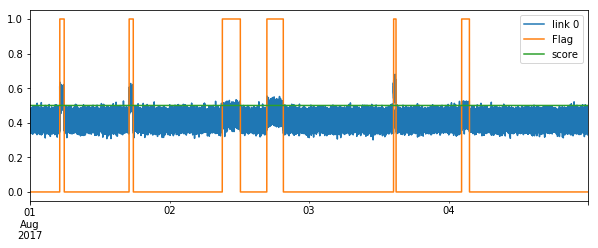

In [6]:
df.plot(figsize=(10,3.5))

#### create NN

In [7]:
def getModel():
    model = Sequential()
    L1 = Dense(units=n_series, input_shape=(n_series,), activation='relu' )
    model.add(L1)
    #L2=Dense(units=n_series, activation='relu')
    #model.add(L2)
    L3 = Dense(units=1, activation='relu') # sigmoid
    model.add(L3)
#     model.compile(loss='hinge', optimizer='sgd', metrics=['binary_accuracy'])
    model.compile(loss='mse',optimizer='rmsprop', metrics=['accuracy'])
#     model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['binary_accuracy'])
    return model

def plotHist(hist):
    es=len(hist.history['loss'])
    x = np.linspace(0,es-1,es)
    plt.plot(x, hist.history['loss'], '--', linewidth=2, label='loss')
    plt.plot(x, hist.history['acc'], '-', linewidth=2, label='acc')
    plt.legend()
    plt.show()

#### functions

In [ ]:
def check_for_anomaly(ref, sub):
    
    y_ref = pd.DataFrame([0] * ref.shape[0])
    y_ref.index=ref.index
    X_ref=ref
    del X_ref['Flag']
    del X_ref['score']
    
    y_sub = pd.DataFrame([1] * sub.shape[0])
    y_sub.index=sub.index
    X_sub=sub
    del X_sub['Flag']
    del X_sub['score']
    
    # separate Reference and Subject into Train and Test
    X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size=0.3, random_state=42)
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
    
    # combine training ref and sub samples
    X_train = pd.concat([X_ref_train, X_sub_train])
    y_train = pd.concat([y_ref_train, y_sub_train])

    # combine testing ref and sub samples
    X_test = pd.concat([X_ref_test, X_sub_test])
    y_test = pd.concat([y_ref_test, y_sub_test])
    
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    m=getModel()
    hist = m.fit(X_train.values, y_train.values, epochs=500, verbose=0, shuffle=True)#, batch_size=256)

    
    loss_and_metrics = m.evaluate(X_test.values, y_test.values)#, batch_size=256)
    #print(loss_and_metrics)

    if loss_and_metrics[1] > cut: 
        plotHist(hist)
#         plot_roc(fpr, tpr, auc_score)
#         filename='tree_'+sub.index.min().strftime("%Y-%m-%d_%H")
#         tree.export_graphviz(clf.estimators_[0] , out_file=filename +'_1.dot') 
#         tree.export_graphviz(clf.estimators_[1] , out_file=filename +'_2.dot') 
        
    return loss_and_metrics[1]

#### Looping over time intervals

In [ ]:
#find min and max timestamps

start = df.index.min()
end = df.index.max()

#round start 
start.seconds=0
start.minutes=0


# loop over them
ti=start+ref+sub
count=0
while ti < end + 1 * Minute():
    print(count)
    ref_start = ti-ref-sub
    ref_end = ti-sub
    ref_df = df[(df.index >= ref_start) & (df.index < ref_end)]
    sub_df = df[(df.index >= ref_end) & (df.index < ti)]
    score = check_for_anomaly(ref_df, sub_df)
    df.loc[(df.index>=ref_end) & (df.index<=ti),['score']] = score
    print(ti,"\trefes:" , ref_df.shape[0], "\tsubjects:", sub_df.shape[0], '\tscore:', score)
    ti = ti + sub
    count=count+1
#     if count>2: break
    


0
6560/8640 [=====================>........] - ETA: 0s2017-08-01 08:00:00 	refes: 21600 	subjects: 7200 	score: 0.75
1
8512/8640 [============================>.] - ETA: 0s2017-08-01 10:00:00 	refes: 21600 	subjects: 7200 	score: 0.75
2
8352/8640 [============================>.] - ETA: 0s2017-08-01 12:00:00 	refes: 21600 	subjects: 7200 	score: 0.75
3


In [ ]:
df.plot(figsize=(20,7))


In [ ]:
fig, ax = plt.subplots(figsize=(20,7))
df.loc[:,'Detected'] = 0
df.loc[df.score>cut,'Detected']=1
df.head()
ax.plot(df.Flag, 'r')
ax.plot(df.score,'g')
ax.fill( df.Detected, 'b', alpha=0.3)
ax.legend(loc='upper left')
plt.show()

In [ ]:
def plot_roc(fpr,tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], linestyle='--', color='r',label='Luck', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()